# Healthcare Analysis

# Imports

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [66]:
def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupes {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels= unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.ylabel("Frequency")
  plt.show()

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def aggregate_dataset(df,agg_col, col, function):
  
  plt.figure(figsize=(10,7))

  grouped_df = getattr(df.groupby(agg_col)[col],function)().reset_index(name=col)
  sns.barplot(data=grouped_df, x=agg_col, y=col)
  plt.title(f"Agg of {col}")
  plt.ylabel(col)
  plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor,model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [33]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,eLIZABeTH jaCkSOn,42,Female,O+,Asthma,2020-08-16,Joshua Jarvis,Jones-Thompson,Blue Cross,2650.714952,417,Elective,2020-09-15,Penicillin,Abnormal
55496,KYle pEREz,61,Female,AB-,Obesity,2020-01-23,Taylor Sullivan,Tucker-Moyer,Cigna,31457.797307,316,Elective,2020-02-01,Aspirin,Normal
55497,HEATher WaNG,38,Female,B+,Hypertension,2020-07-13,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,347,Urgent,2020-08-10,Ibuprofen,Abnormal
55498,JENniFER JOneS,43,Male,O-,Arthritis,2019-05-25,Kimberly Curry,"Jackson Todd and Castro,",Medicare,32451.092358,321,Elective,2019-05-31,Ibuprofen,Abnormal


# Check For Null Values

In [34]:
check_nulls_dupes(df)

The amount of Nulls: Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64
The amount of Dupes 534


In [35]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

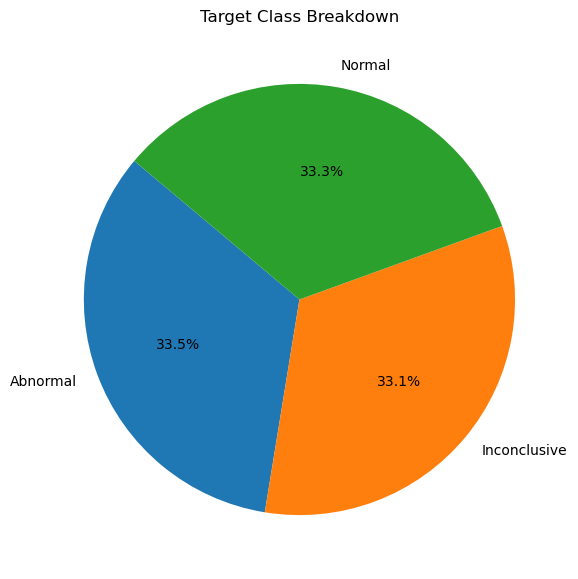

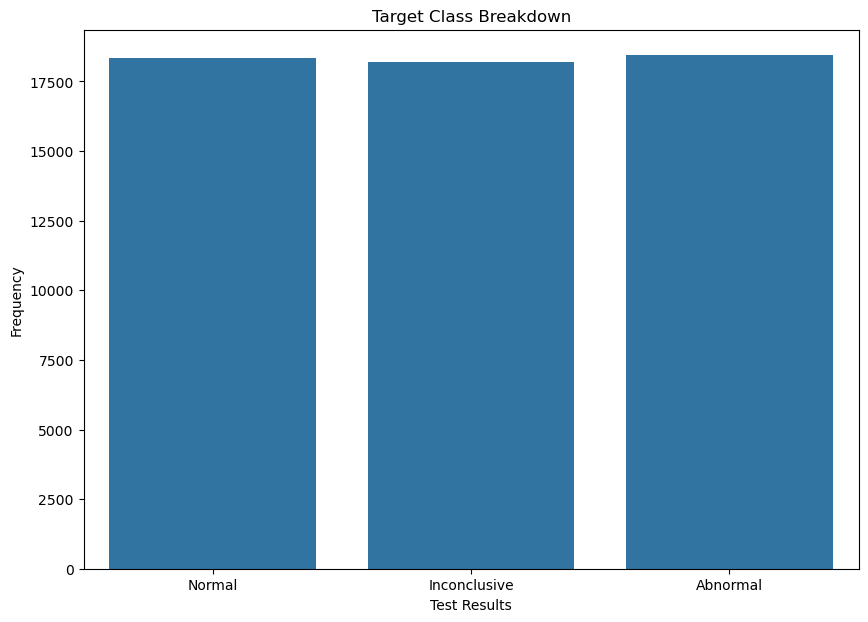

In [36]:
check_class_imbalance(df["Test Results"])

In [37]:
for col in df.select_dtypes(include="object"):
  print(f"{col}")
  print(len(df[col].unique()))

Name
49992
Gender
2
Blood Type
8
Medical Condition
6
Date of Admission
1827
Doctor
40341
Hospital
39876
Insurance Provider
5
Admission Type
3
Discharge Date
1856
Medication
5
Test Results
3


# Feature Engineering

In [38]:
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])

In [39]:
df["duration"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

In [40]:
df.drop(["Name", "Doctor", "Hospital", "Room Number", "Date of Admission", "Discharge Date"], inplace=True, axis=1)

# Split Numeric and Categorical columns

In [41]:
numeric_types = df.select_dtypes(include=["int64", "float64"])
categorical_types = df.select_dtypes(include="object")

In [42]:
df.dtypes

Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Insurance Provider     object
Billing Amount        float64
Admission Type         object
Medication             object
Test Results           object
duration                int64
dtype: object

In [43]:
df.describe()

,Age,Billing Amount,duration
count,54966.000000,54966.000000,54966.000000
mean,51.535185,25544.306284,15.499290
std,19.605661,14208.409711,8.661471
min,13.000000,-2008.492140,1.000000
25%,35.000000,13243.718641,8.000000
50%,52.000000,25542.749145,15.000000
75%,68.000000,37819.858159,23.000000
max,89.000000,52764.276736,30.000000


# Heatmap

<Axes: >

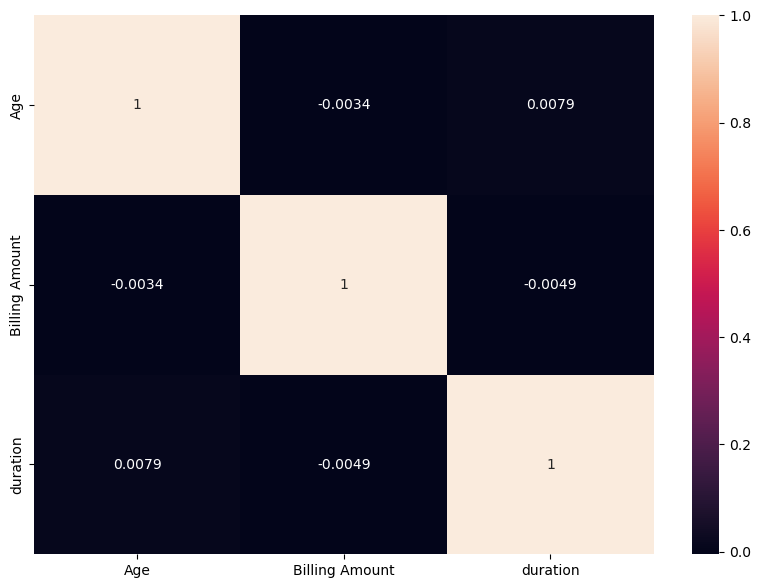

In [45]:
relations = numeric_types.corr()
plt.figure(figsize=(10,7))
sns.heatmap(data=relations, annot=True)

# Distribution Graph

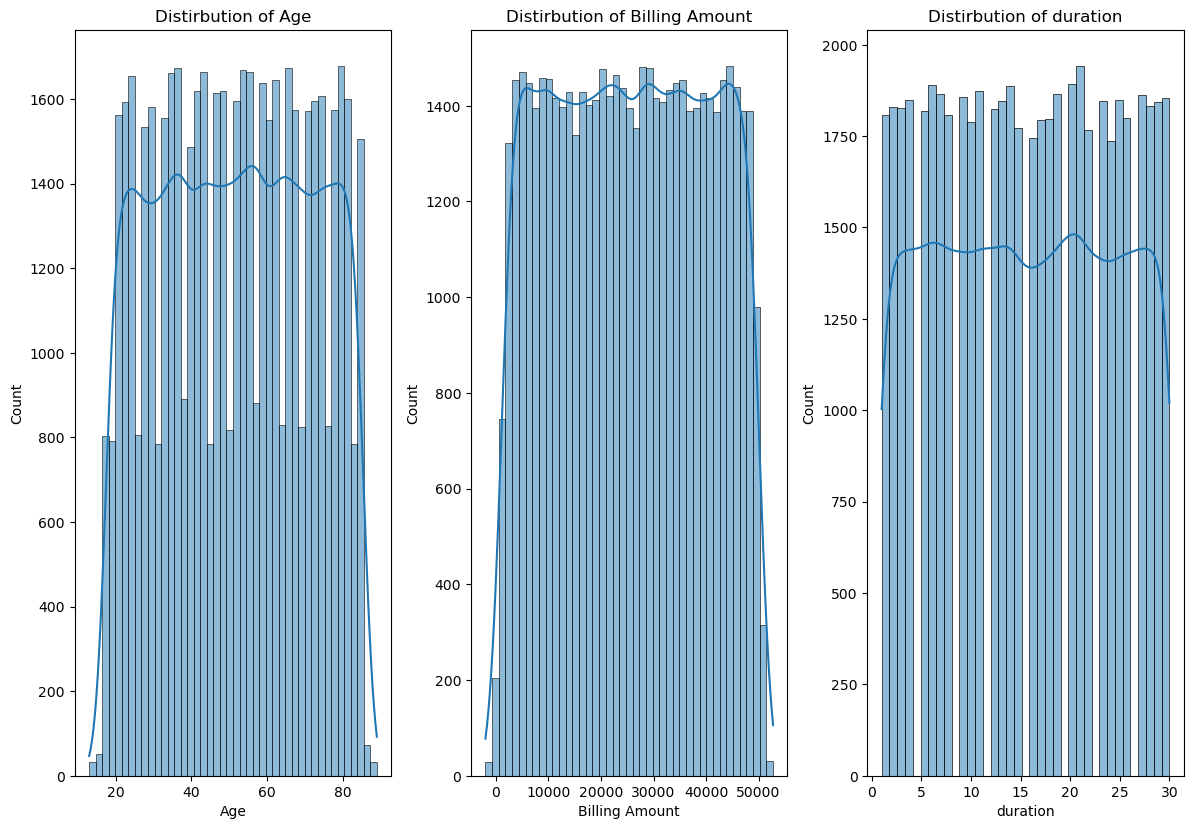

In [47]:
plot_distribution(numeric_types, "hist")

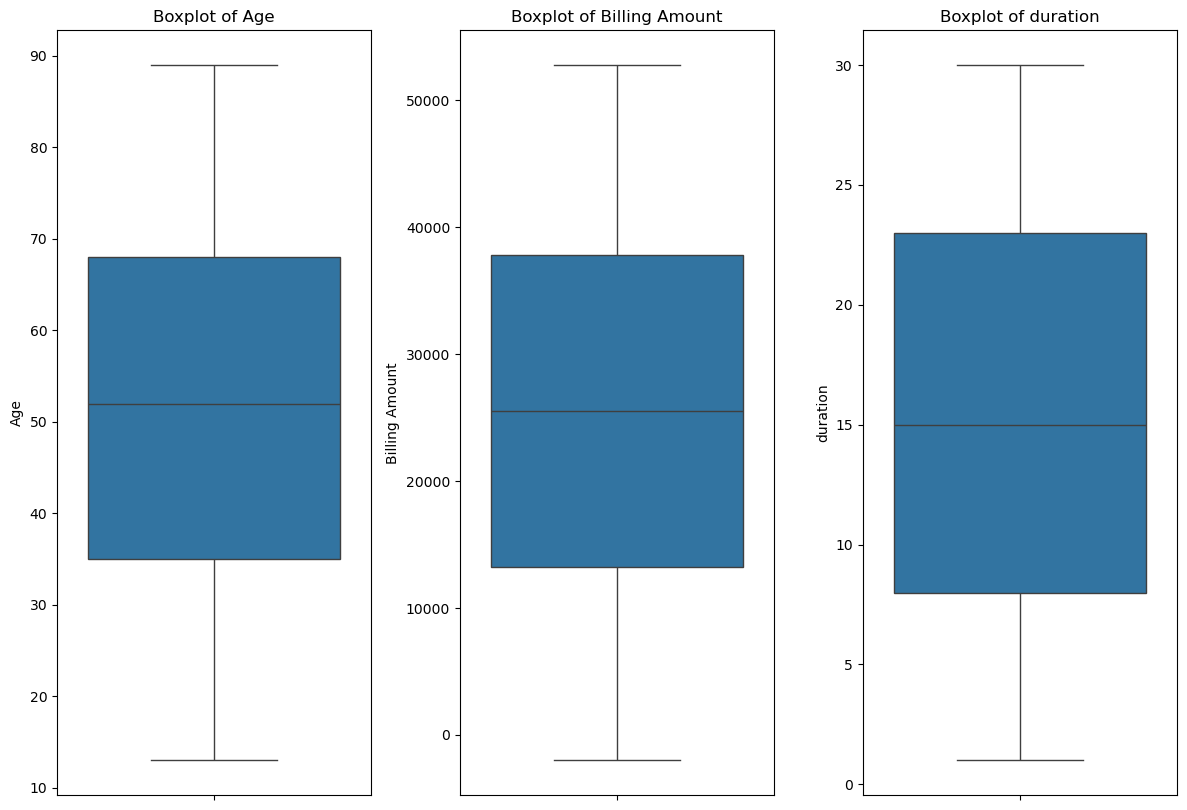

In [48]:
plot_distribution(numeric_types, "box")

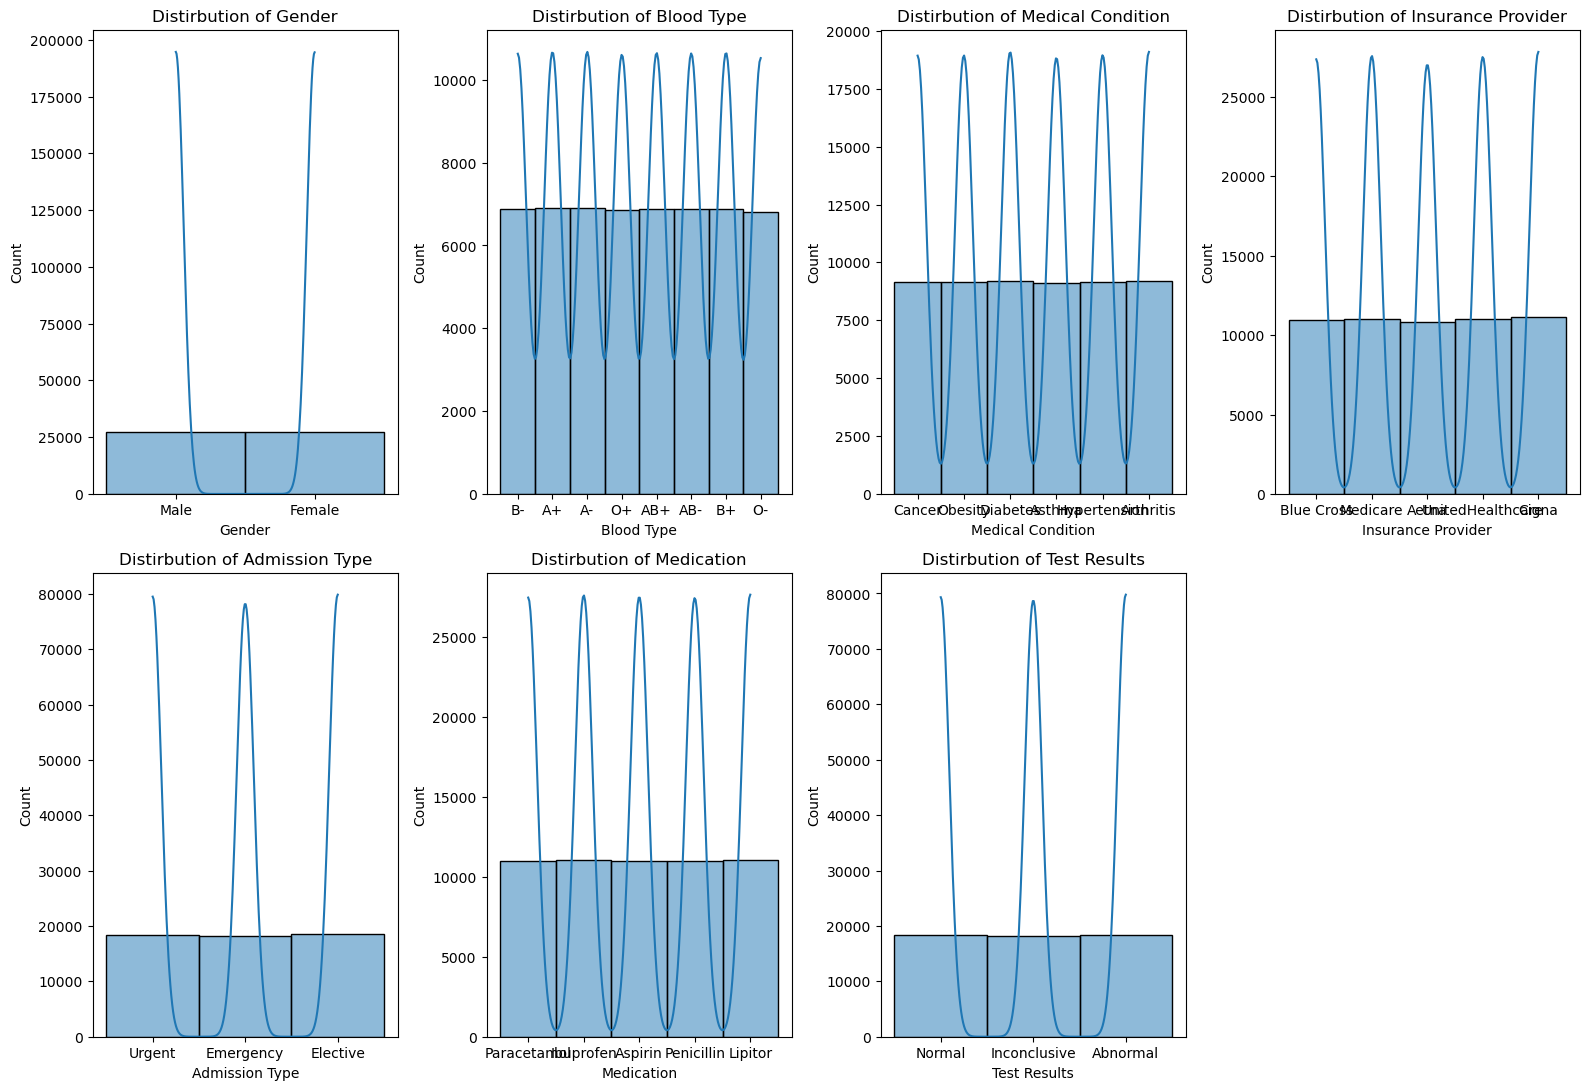

In [49]:
plot_distribution(categorical_types, "hist")

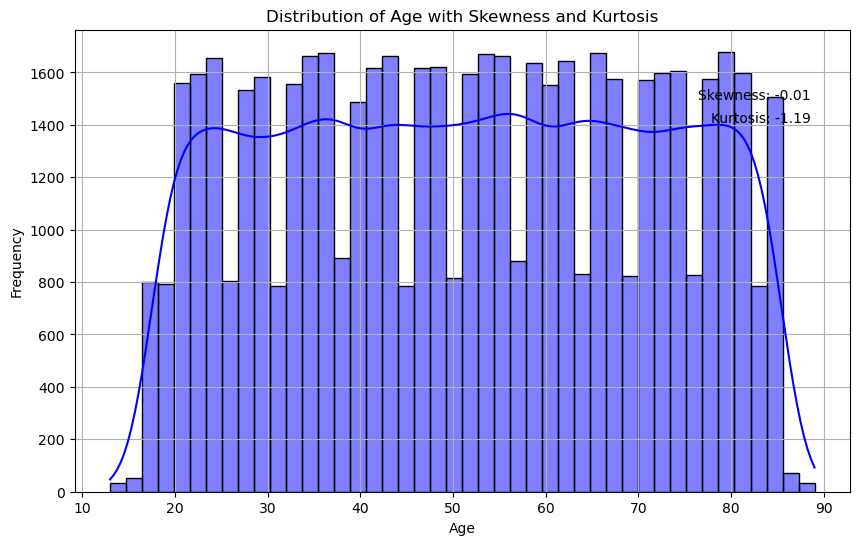

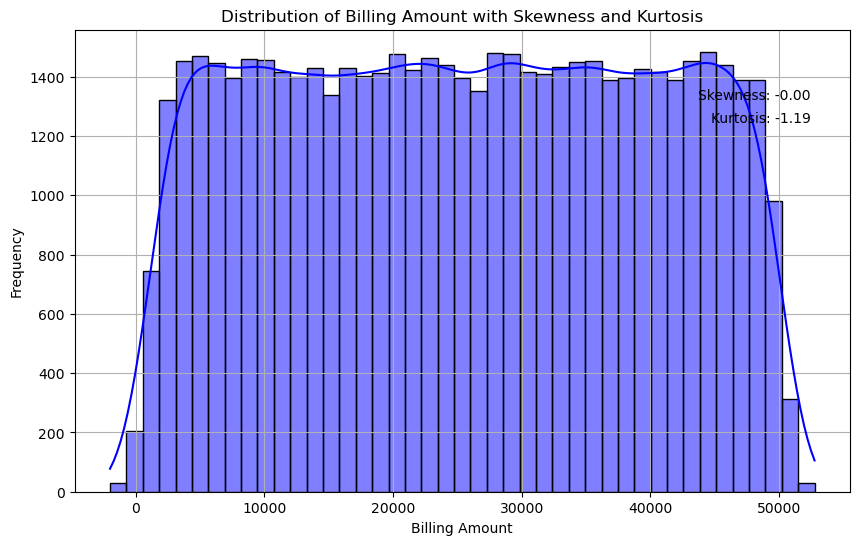

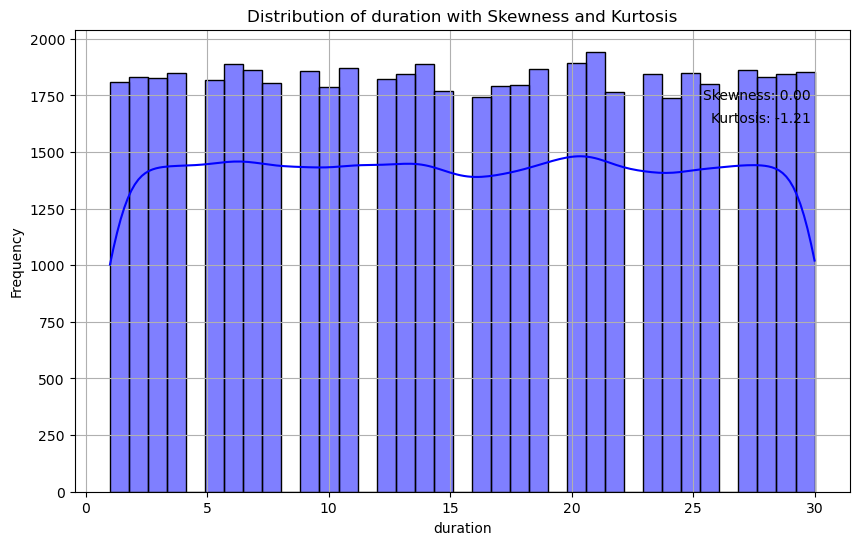

In [51]:
for col in numeric_types.columns:
  dist_plot(df, col)

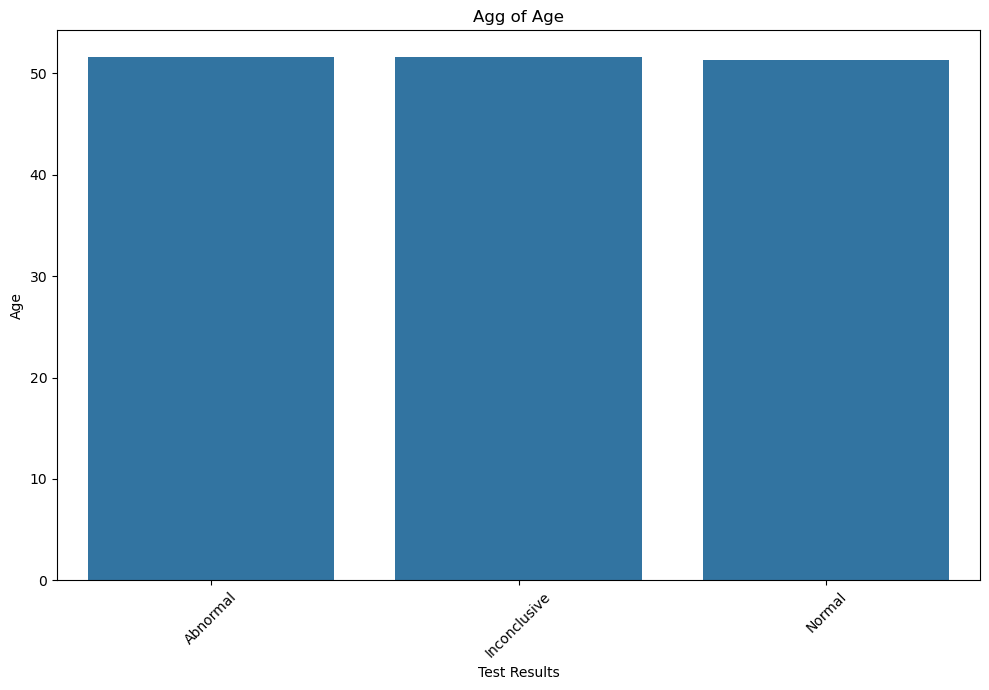

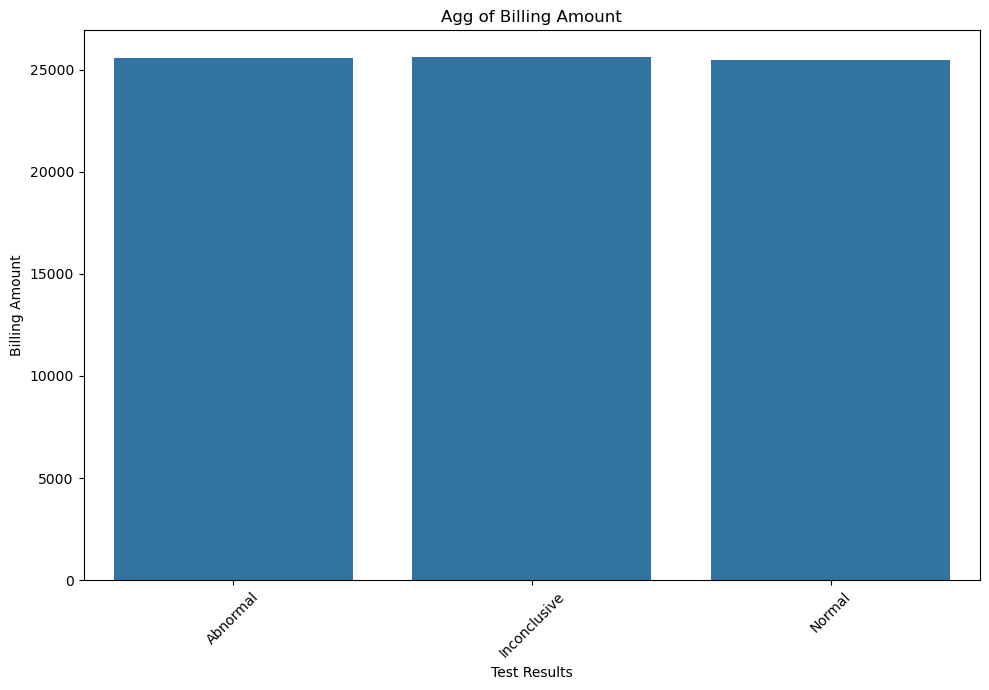

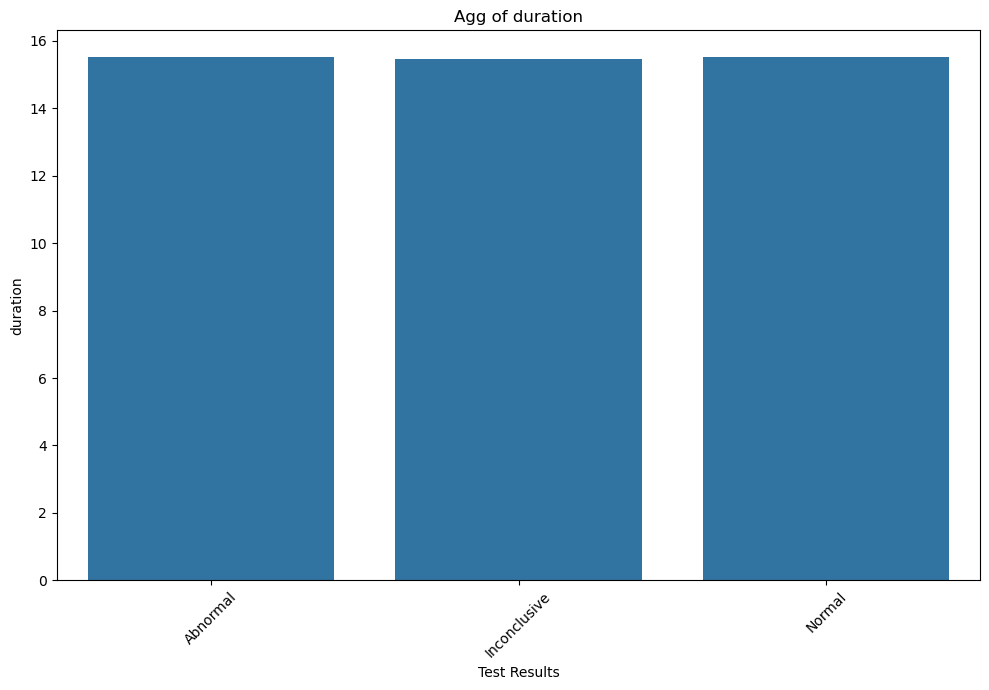

In [55]:
for col in numeric_types.columns:
  aggregate_dataset(df, "Test Results", col, "mean")

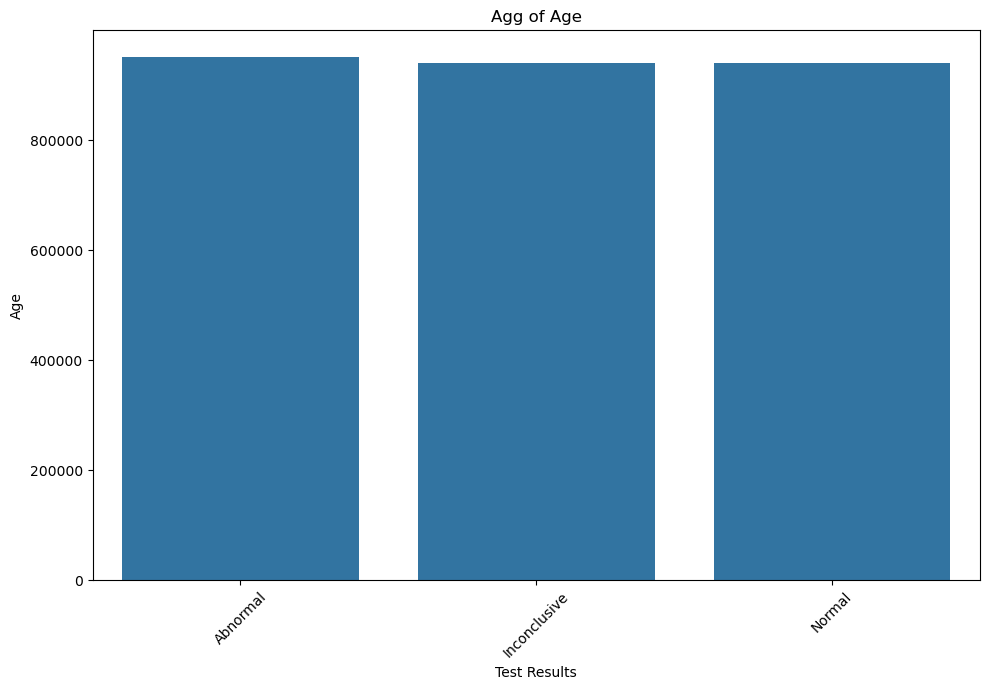

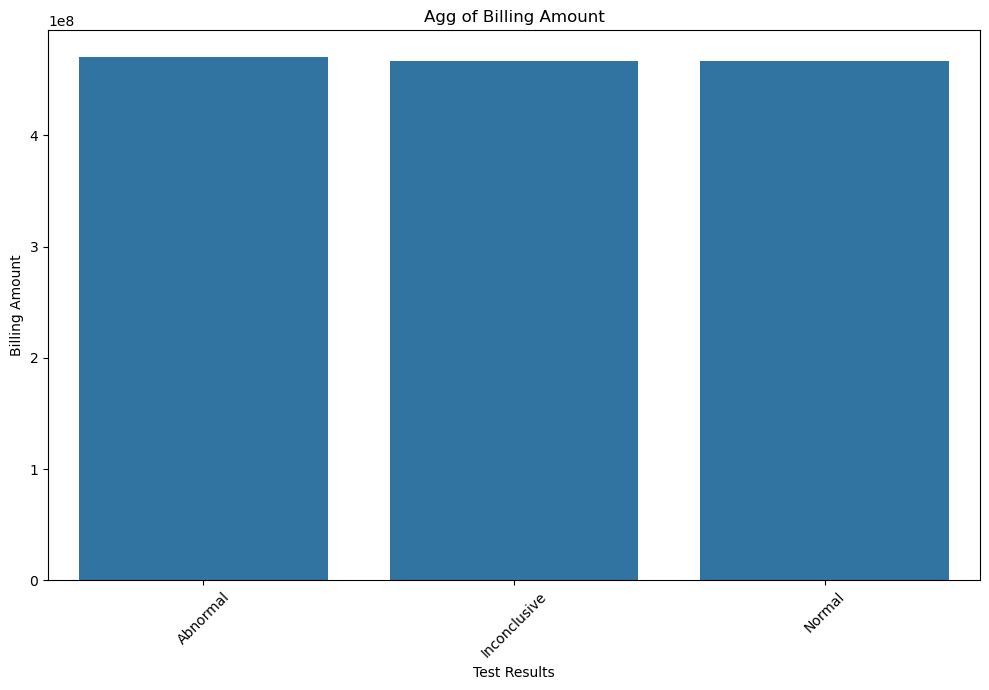

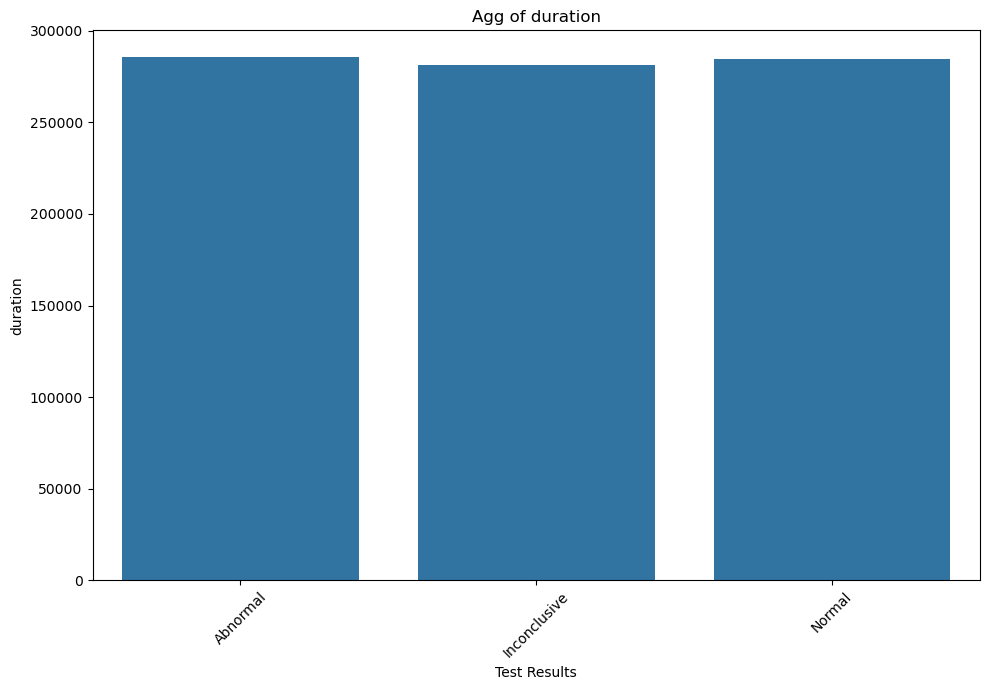

In [56]:
for col in numeric_types.columns:
  aggregate_dataset(df, "Test Results", col, "sum")

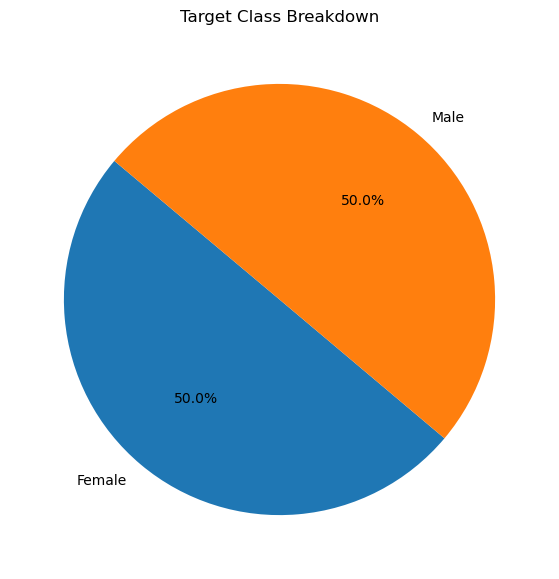

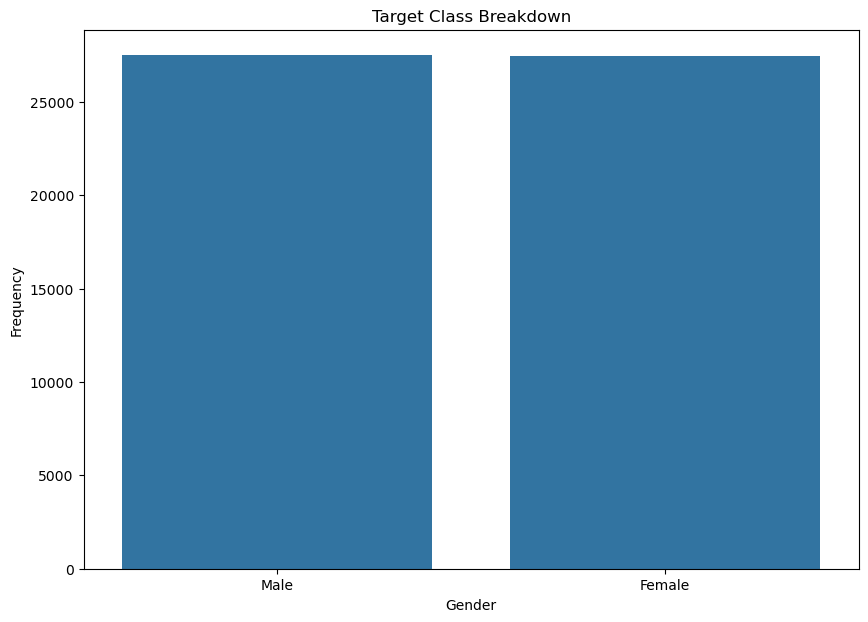

In [59]:
check_class_imbalance(df["Gender"])

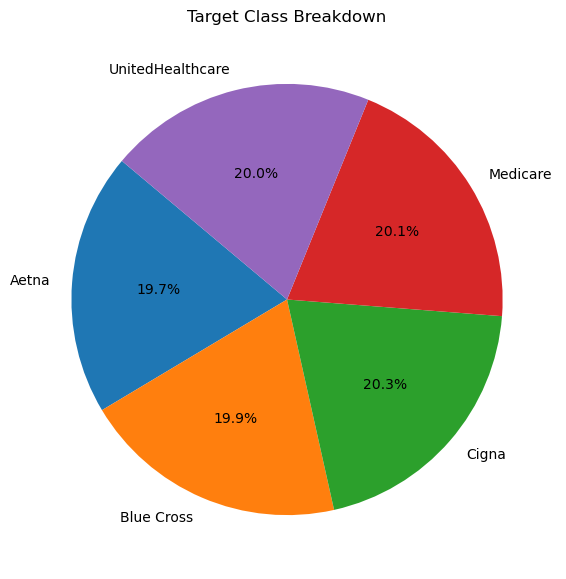

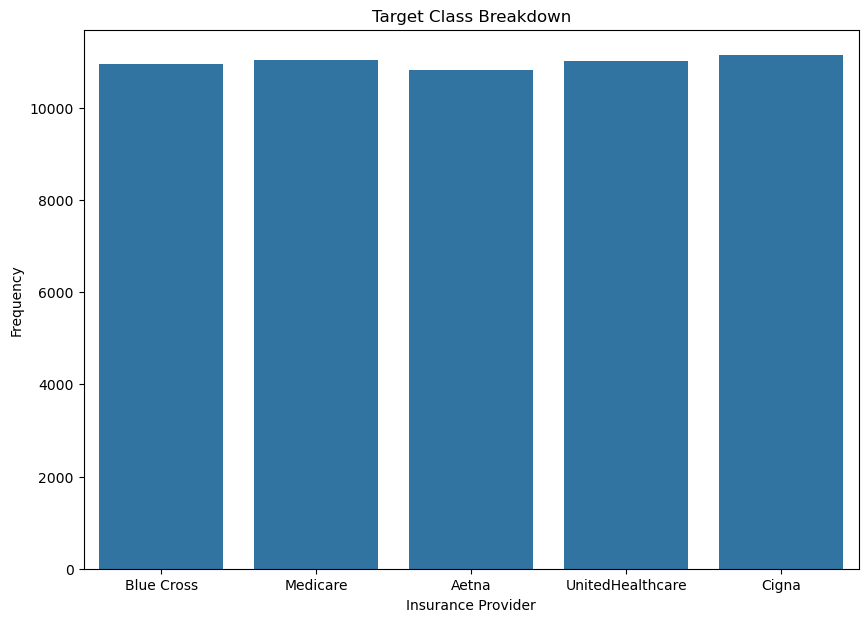

In [60]:
check_class_imbalance(df["Insurance Provider"])

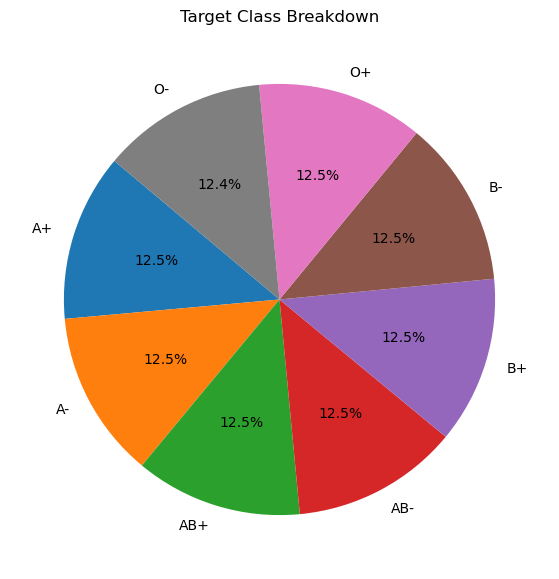

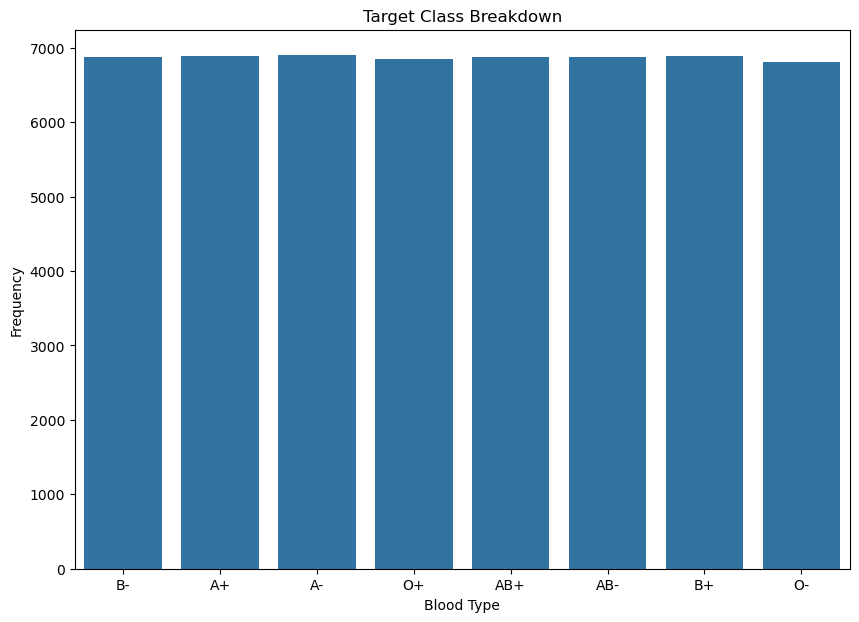

In [61]:
check_class_imbalance(df["Blood Type"])

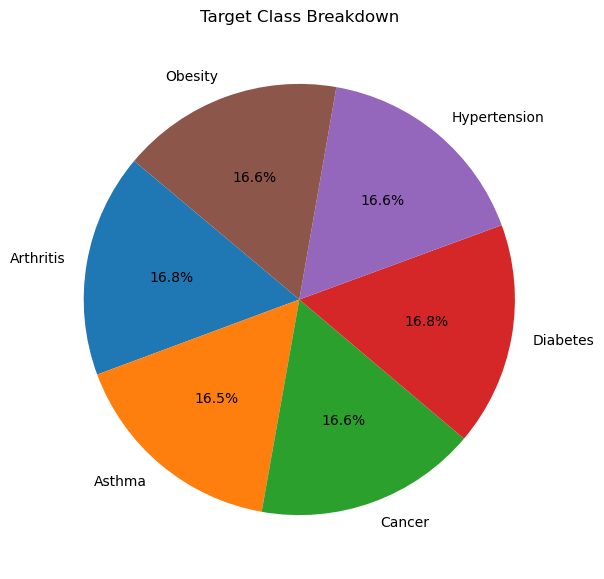

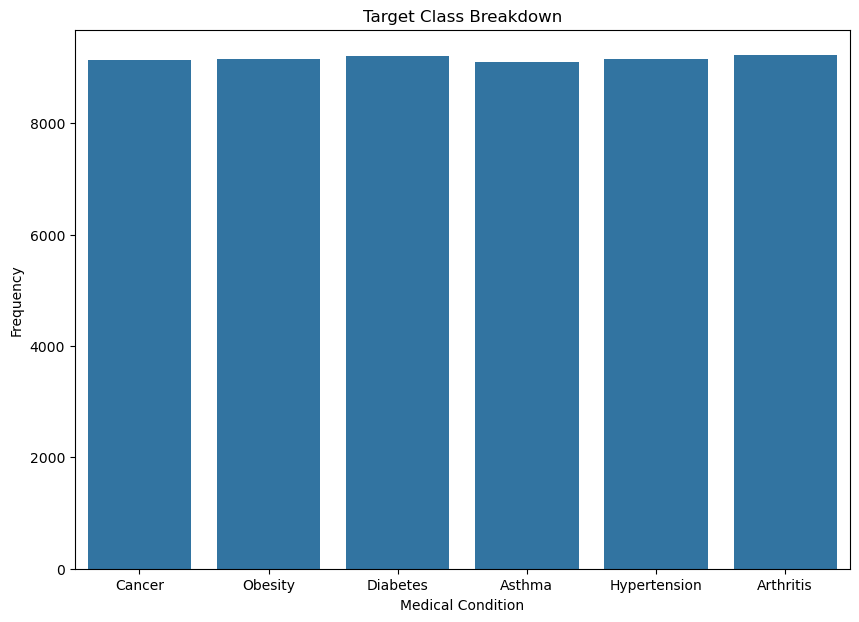

In [62]:
check_class_imbalance(df["Medical Condition"])

# Separate X and y variables

In [63]:
X, y = df.drop("Test Results", axis=1), df["Test Results"]

In [68]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Metric Scores

In [64]:

acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="macro")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='macro')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='macro')

In [67]:
categorical_types.drop("Test Results", axis=1, inplace=True)

# Create Preprocessor

In [69]:
preprocessor = create_column_transformer(categorical_types.columns, numeric_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider',
       'Admission Type', 'Medication'],
      dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Billing Amount', 'duration'], dtype='object'))])

# PCA Analysis

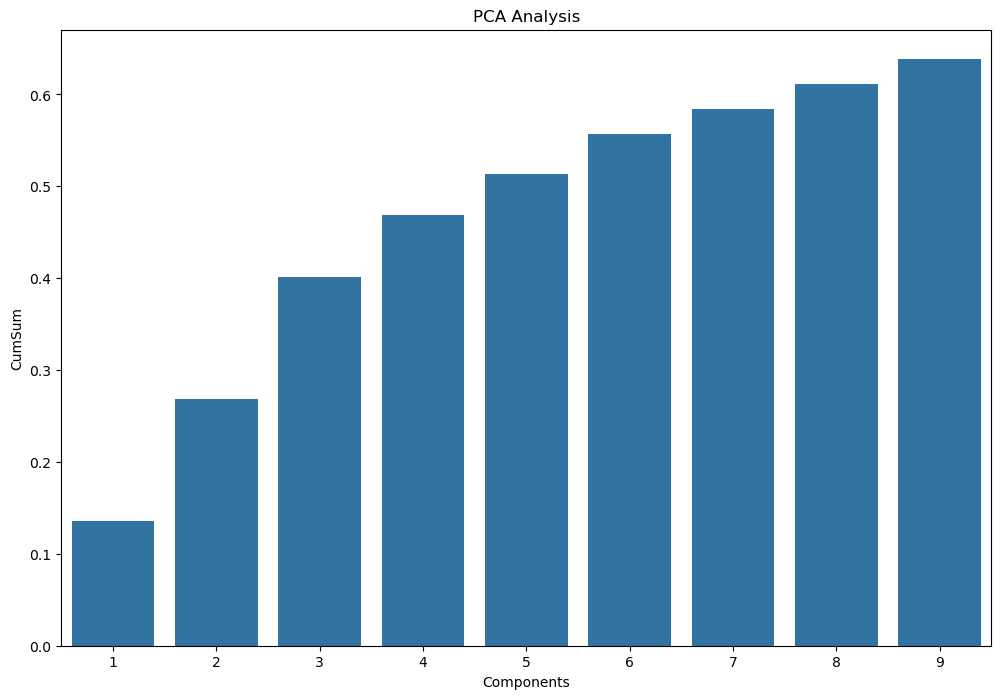

   Component    CumSum
0          1  0.135267
1          2  0.268665
2          3  0.401383
3          4  0.468304
4          5  0.513194
5          6  0.557508
6          7  0.584643
7          8  0.611638
8          9  0.638569


In [72]:
pca_analysis(X, preprocessor)

# Test Baseline

In [73]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.333  0.0  0.007     0.331         0.331            0.331     0.331


# Test K Best Columns

In [74]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is il

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.332819,0.263270,0.331521,0.222006
1,LR,2,0.335024,0.266853,0.333804,0.223434
2,LR,3,0.334307,0.266313,0.333092,0.222920
3,LR,4,0.332874,0.301698,0.331931,0.337934
4,LR,5,0.334307,0.322757,0.333708,0.335475
5,LR,6,0.336016,0.324412,0.335406,0.336900
6,LR,7,0.335796,0.325262,0.335203,0.337727
7,LR,8,0.337284,0.326557,0.336705,0.338266
8,LR,9,0.335520,0.327386,0.335001,0.335825


In [75]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.334087,0.265916,0.332858,0.222779
1,LR,2,0.336071,0.314691,0.335296,0.335506
2,LR,3,0.333150,0.321004,0.332531,0.333532
3,LR,4,0.334087,0.322668,0.333480,0.334237
4,LR,5,0.337174,0.326070,0.336567,0.338507
5,LR,6,0.336568,0.325822,0.335984,0.337096
6,LR,7,0.336788,0.328684,0.336266,0.337171
7,LR,8,0.333425,0.325618,0.332917,0.334061
8,LR,9,0.333425,0.324945,0.332901,0.333476


In [76]:
kbest = SelectKBest(score_func=f_classif, k=5)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, acc_metric, kbest)

/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/web-scraping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped whi

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   SVC  0.334  0.0  0.005     0.334         0.334            0.333     0.319
1    LR  0.334  0.0  0.005     0.336         0.335            0.334     0.316
2   KNN  0.334  0.0  0.008     0.331         0.331            0.331     0.316


# The Data is synthetically created, thus there exist no predictive capabilities